In [1]:
#import gsw as sw # Gibbs seawater package

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import warnings
warnings.filterwarnings("ignore")
import xarray as xr

import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
sns.set_context('talk')
sns.set_style('white')

In [3]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/data/kramosmu/results/TracerExperiments/CNTDIFF/run68/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [4]:
grid_file1 = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/gridGlob.nc'
state_file2 = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/stateGlob.nc'

with Dataset(grid_file1, 'r') as nbl:
    Z1 = nbl.variables['RC'][:]
    hfac = nbl.variables['HFacC'][:,:,:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
with Dataset(state_file2,'r') as stfl:
    time = stfl.variables['T'][:]

mask = rout.getMask(grid_file1,'HFacC')    
nx = 616
ny = 360
nz = 90

In [5]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh= 97.5 # head depth
Hr = 132.0 # rim depth at DnS
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

In [6]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 
records = canyon_records.main()

import nocanyon_records 
recordsNoC = nocanyon_records.main()

In [7]:
# Indices of all runs that will be considered for paper 1

select_rec = [0,1,2,3,4,5,51,6,7,8,9,10,17,18,19,20,21,
              22,23,24,25,26,27,28,29,30,31,32,33,
              34,35,38,39,41,42,43,44,45,46,47,48,49]



In [8]:
# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,38,39,45,46,47,48,49]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,
       34,35,38,39,41,42,43,44,45,46,47,48,49]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_real has all the runs in records_epsilon plus the realistic runs
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,24,25,26,27,28,29,30,31,32,33,
       34,35,38,39,41,42,43,44,45,46,47,48,49]
records_real = []
for ii in ind:
    records_real.append(records[ii])

# records_diffusivity has all the runs with step and epsilon kv profiles; it does not have the dynamics runs
ind = [29,30,31,32,33,34,35,38,39,41,42,43,44,45,46,47,48,49]
records_diffusivity = []
for ii in ind:
    records_diffusivity.append(records[ii])

    
# records_kv has the runs with step kv profile
ind = [28,32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,20,21,22,29,30,31,32,33,34,35,41,42,43,44]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,51,6,7,8,9,10,17,18,19,21,22]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [9]:
for rec in records_diffusivity:
    print(ii,rec.label2,rec.run_num, rec.kbg)
    

22 $\Uparrow \Uparrow K_{can}$, $\epsilon 10$ run07 1e-05
22 $\Uparrow \Uparrow K_{can}$, $\epsilon 25$ run08 1e-05
22 $\Uparrow \Uparrow K_{can}$, $\epsilon 50$ run09 1e-05
22 $\Uparrow \Uparrow K_{can}$, $\epsilon 100$ run10 1e-05
22 $\Uparrow \Uparrow K_{can}$, $\epsilon 15$ run11 1e-05
22 $\Uparrow \Uparrow K_{can}$, $\epsilon 75$ run12 1e-05
22 $\Uparrow \Uparrow K_{can}$, $\epsilon 150$ run13 1e-05
22 $\uparrow \uparrow K_{can}$ run16 1e-05
22 $\Uparrow \uparrow K_{can}$ run17 1e-05
22 $\uparrow \uparrow K_{can}$ $\epsilon 25$ run19 1e-05
22 $\uparrow \uparrow K_{can}$ $\epsilon 100$ run20 1e-05
22 $\Uparrow \uparrow K_{can}$ $\epsilon 25$ run21 1e-05
22 $\Uparrow \uparrow K_{can}$, $\epsilon 100$ run22 1e-05
22 $\Uparrow \uparrow \uparrow K_{can}$ run23 1e-05
22 $\Uparrow \Uparrow \uparrow K_{can}$ run24 1e-05
22 $\Uparrow K_{can}$ run25 1e-05
22 $\uparrow K_{can}$ run26 1e-05
22 $\Uparrow \Uparrow K_{can}$ run27 1e-05


### Stratification

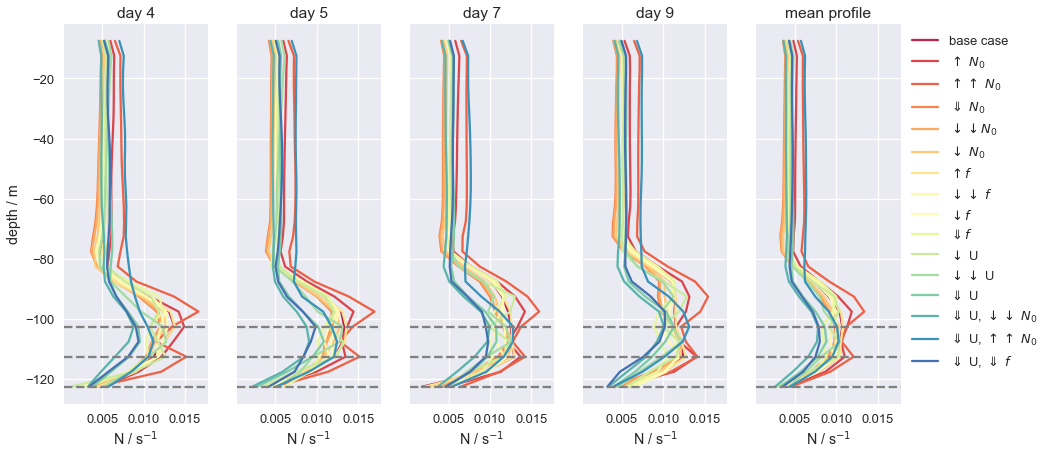

In [20]:
keys = ['N_tt08','N_tt10','N_tt14','N_tt18']
keys2 = ['N_tt08','N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']

days = ['4','5','7','9']
sns.set_style('darkgrid')

stname = 'UwH' # Station at downstream head side of canyon

fig, ax = plt.subplots(1,len(keys)+1,figsize=(15,7), sharey = True, sharex = True)

sns.set_palette('Spectral',len(records_dyn))

for rec in records_dyn:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s_%s.csv' %
                 (rec.exp_code,rec.run_num,stname))
    df = pd.read_csv(filename1)
    
    Nab = 0
    Nbe = 0
    Nmean = np.zeros((len(df[keys2[0]][:]),len(keys2)))
    
    for key,ii,day in zip(keys, range(len(keys)), days):
        ax[ii].plot(df[keys[ii]][:],Z1[1:-1],  
                    label = rec.label2)  
        ax[ii].set_title('day %s' %day)
        
    for key,ii in zip(keys2, range(len(keys2)-1)):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:24]) #20:24
        Nmean[:,ii] = df[keys2[ii]][:]
        
    rec.Nab_h = Nab/  len(keys2)
    rec.Nbe_h = Nbe/  len(keys2)
    rec.Nmean_h = np.mean(Nmean,axis=1)    
    ax[len(keys)].plot(rec.Nmean_h,Z1[1:-1], label=rec.label2)  
    ax[len(keys)].set_title('mean profile')  
                    
for ii in range(len(keys)+1):
    ax[ii].set_xlabel('N / s$^{-1}$')
    ax[ii].axhline(Z1[20],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[22],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[24],color = '0.5', linestyle = '--') # rim depth
    
ax[0].set_ylabel('depth / m')
ax[len(keys)].legend(bbox_to_anchor=(1,1))    
    


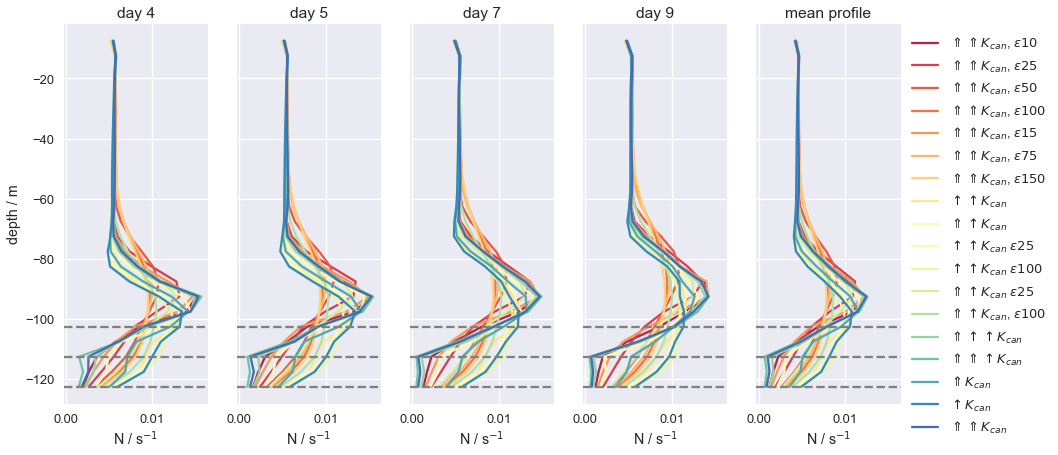

In [22]:
keys = ['N_tt08','N_tt10','N_tt14','N_tt18']
keys2 = ['N_tt08','N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']

days = ['4','5','7','9']
sns.set_style('darkgrid')

stname = 'UwH' # Station at downstream head side of canyon

fig, ax = plt.subplots(1,len(keys)+1,figsize=(15,7), sharey = True, sharex = True)

sns.set_palette('Spectral',len(records_diffusivity))

for rec in records_diffusivity:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s_%s.csv' %
                 (rec.exp_code,rec.run_num,stname))
    df = pd.read_csv(filename1)
    
    Nab = 0
    Nbe = 0
    Nmean = np.zeros((len(df[keys2[0]][:]),len(keys2)))
    
    for key,ii,day in zip(keys, range(len(keys)), days):
        ax[ii].plot(df[keys[ii]][:],Z1[1:-1],  
                    label = rec.label2)  
        ax[ii].set_title('day %s' %day)
        
    for key,ii in zip(keys2, range(len(keys2)-1)):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:24]) #20:24
        Nmean[:,ii] = df[keys2[ii]][:]
        
    rec.Nab_h = Nab/  len(keys2)
    rec.Nbe_h = Nbe/  len(keys2)
    rec.Nmean_h = np.mean(Nmean,axis=1)    
    ax[len(keys)].plot(rec.Nmean_h,Z1[1:-1], label=rec.label2)  
    ax[len(keys)].set_title('mean profile')  
                    
for ii in range(len(keys)+1):
    ax[ii].set_xlabel('N / s$^{-1}$')
    ax[ii].axhline(Z1[20],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[22],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[24],color = '0.5', linestyle = '--') # rim depth
    
ax[0].set_ylabel('depth / m')
ax[len(keys)].legend(bbox_to_anchor=(1,1))    
    


### Concentration

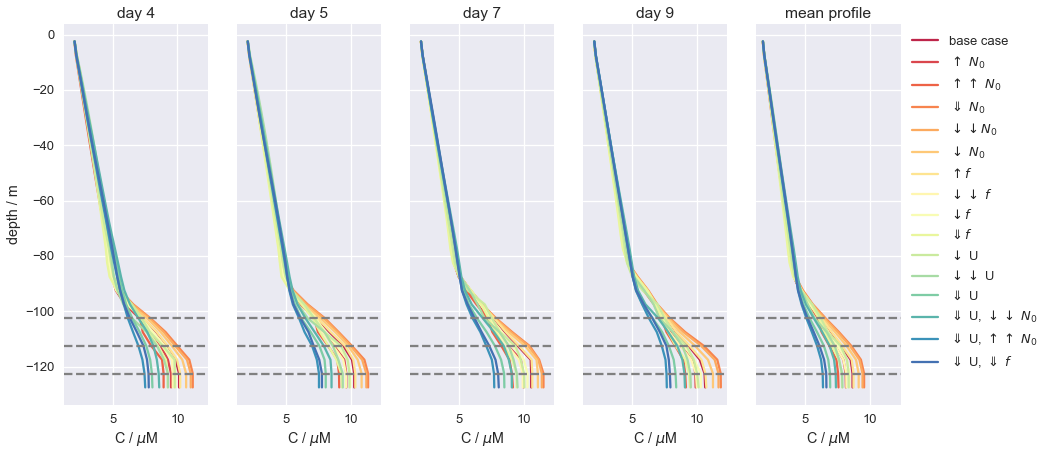

In [24]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt14','Tr_profile_tt18']
keys2 = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16','Tr_profile_tt18']

days = ['4','5','7','9']
sns.set_style('darkgrid')

stname = 'UwH' # Station at downstream head side of canyon

fig, ax = plt.subplots(1,len(keys)+1,figsize=(15,7), sharey = True, sharex = True)

sns.set_palette('Spectral',len(records_dyn))

for rec in records_dyn:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (rec.name,stname))
    df = pd.read_csv(filename1)
    
    Nab = 0
    Nbe = 0
    Nmean = np.zeros((len(df[keys2[0]][:]),len(keys2)))
    
    for key,ii,day in zip(keys, range(len(keys)), days):
        ax[ii].plot(df[keys[ii]][:],Z1[:],  
                    label = rec.label2)  
        ax[ii].set_title('day %s' %day)
        
    for key,ii in zip(keys2, range(len(keys2)-1)):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:24]) #20:24
        Nmean[:,ii] = df[keys2[ii]][:]
        
    rec.Nab_h = Nab/  len(keys2)
    rec.Nbe_h = Nbe/  len(keys2)
    rec.Nmean_h = np.mean(Nmean,axis=1)    
    ax[len(keys)].plot(rec.Nmean_h,Z1[:], label=rec.label2)  
    ax[len(keys)].set_title('mean profile')  
                    
for ii in range(len(keys)+1):
    ax[ii].set_xlabel('C / $\mu$M')
    ax[ii].axhline(Z1[20],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[22],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[24],color = '0.5', linestyle = '--') # rim depth
    
ax[0].set_ylabel('depth / m')
ax[len(keys)].legend(bbox_to_anchor=(1,1))    
    


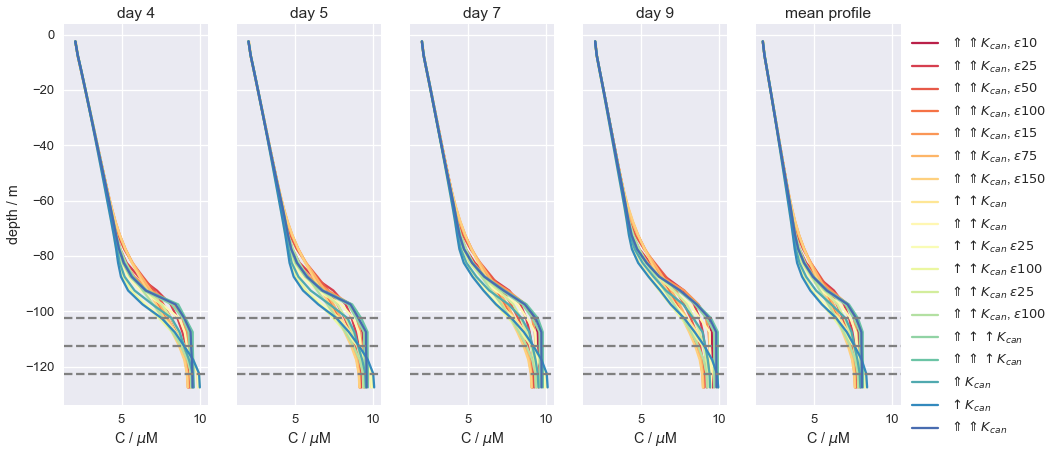

In [26]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt14','Tr_profile_tt18']
keys2 = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16','Tr_profile_tt18']

days = ['4','5','7','9']
sns.set_style('darkgrid')

stname = 'UwH' # Station at downstream head side of canyon

fig, ax = plt.subplots(1,len(keys)+1,figsize=(15,7), sharey = True, sharex = True)

sns.set_palette('Spectral',len(records_diffusivity))

for rec in records_diffusivity:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (rec.name,stname))
    df = pd.read_csv(filename1)
    
    Nab = 0
    Nbe = 0
    Nmean = np.zeros((len(df[keys2[0]][:]),len(keys2)))
    
    for key,ii,day in zip(keys, range(len(keys)), days):
        ax[ii].plot(df[keys[ii]][:],Z1[:],  
                    label = rec.label2)  
        ax[ii].set_title('day %s' %day)
        
    for key,ii in zip(keys2, range(len(keys2)-1)):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:24]) #20:24
        Nmean[:,ii] = df[keys2[ii]][:]
        
    rec.Nab_h = Nab/  len(keys2)
    rec.Nbe_h = Nbe/  len(keys2)
    rec.Nmean_h = np.mean(Nmean,axis=1)    
    ax[len(keys)].plot(rec.Nmean_h,Z1[:], label=rec.label2)  
    ax[len(keys)].set_title('mean profile')  
                    
for ii in range(len(keys)+1):
    ax[ii].set_xlabel('C / $\mu$M')
    ax[ii].axhline(Z1[20],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[22],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[24],color = '0.5', linestyle = '--') # rim depth
    
ax[0].set_ylabel('depth / m')
ax[len(keys)].legend(bbox_to_anchor=(1,1))    
    


### Find scaling relations

In [14]:
keys2 = ['N_tt08','N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']
stname = 'UwH' # Station at downstream head side of canyon
t = 6.5

for rec in records_epsilon:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s_%s.csv' %
                 (rec.exp_code,rec.run_num,stname))
    df = pd.read_csv(filename1)
    
    Nab = 0
    Nbe = 0
    Nmean = np.zeros((len(df[keys2[0]][:]),len(keys2)))
    
    for key,ii in zip(keys2, range(len(keys2)-1)):
        Nab = Nab + np.max(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.min(df[keys2[ii]][20:23]) #20:24
        Nmean[:,ii] = df[keys2[ii]][:]
        
    rec.Nab_h = Nab/  len(keys2)
    rec.Nbe_h = Nbe/  len(keys2)
    rec.Nmean_h = np.mean(Nmean,axis=1)    
    rec.Nab_mean = np.max(rec.Nmean_h[:20])
    rec.Nbe_mean = np.min(rec.Nmean_h[20:23])
    rec.Z = ((rec.f*rec.u_mod*F(Ro(rec.u_mod,rec.f,R))*L)**(0.5))/rec.N
    rec.Zdif = np.sqrt(t*3600*24*((rec.kv-rec.kbg)))
    
    rec.N0 = df['N_tt00'][15]

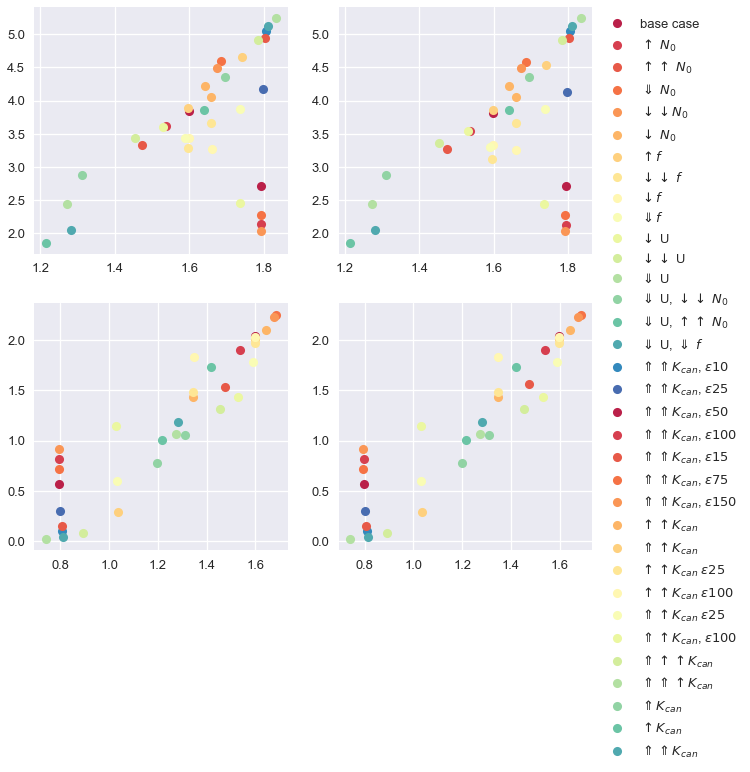

In [15]:
fig, ax = plt.subplots(2,2,figsize=(10,10))

sns.set_palette('Spectral',len(records_epsilon))

for rec in records_epsilon:
    rec.nu = (rec.epsilon**2)/(rec.kv/rec.N)
    ax[0,0].plot((1+(rec.Z+0.3*rec.Zdif)/Hh),(rec.Nab_h/rec.N)**2,'o', label=rec.label2)
    ax[0,1].plot((1+(rec.Z+0.3*rec.Zdif)/Hh),(rec.Nab_mean/rec.N)**2,'o',label=rec.label2)
    ax[1,0].plot((1+(rec.Z-rec.Zdif)/Hh),(rec.Nbe_h/rec.N)**2,'o', label=rec.label2)
    ax[1,1].plot((1+(rec.Z-rec.Zdif)/Hh),(rec.Nbe_mean/rec.N)**2,'o',label=rec.label2)
ax[0,1].legend(bbox_to_anchor=(1,1))

In [16]:
for rec in records_epsilon:
    print(rec.label2,rec.f)

base case 9.66e-05
$\uparrow$ $N_0$ 9.66e-05
$\uparrow \uparrow$ $N_0$ 9.66e-05
$\Downarrow$ $N_0$ 9.66e-05
$\downarrow \downarrow N_0$ 9.66e-05
$\downarrow$ $N_0$ 9.66e-05
$\uparrow f$ 0.0001
$\downarrow \downarrow$ $f$ 7.68e-05
$\downarrow f$ 8.6e-05
$\Downarrow f$ 6.4e-05
$\downarrow$ U 9.66e-05
$\downarrow \downarrow$ U 9.66e-05
$\Downarrow$ U 9.66e-05
$\Downarrow$ U, $\downarrow \downarrow$ $N_0$ 9.66e-05
$\Downarrow$ U, $\uparrow \uparrow$ $N_0$ 9.66e-05
$\Downarrow$ U, $\Downarrow$ $f$ 7e-05
$\Uparrow \Uparrow K_{can}$, $\epsilon 10$ 9.66e-05
$\Uparrow \Uparrow K_{can}$, $\epsilon 25$ 9.66e-05
$\Uparrow \Uparrow K_{can}$, $\epsilon 50$ 9.66e-05
$\Uparrow \Uparrow K_{can}$, $\epsilon 100$ 9.66e-05
$\Uparrow \Uparrow K_{can}$, $\epsilon 15$ 9.66e-05
$\Uparrow \Uparrow K_{can}$, $\epsilon 75$ 9.66e-05
$\Uparrow \Uparrow K_{can}$, $\epsilon 150$ 9.66e-05
$\uparrow \uparrow K_{can}$ 9.66e-05
$\Uparrow \uparrow K_{can}$ 9.66e-05
$\uparrow \uparrow K_{can}$ $\epsilon 25$ 9.66e-05
$\upa

In [17]:
for rec in records_epsilon:
    file = ('/data/kramosmu/results/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(rec.exp_code,
                                                                                rec.exp_code,
                                                                                rec.run_num))
    dfcan = pd.read_csv(file)
    can_eff = dfcan['HCW']
    rec.Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    rec.Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
        

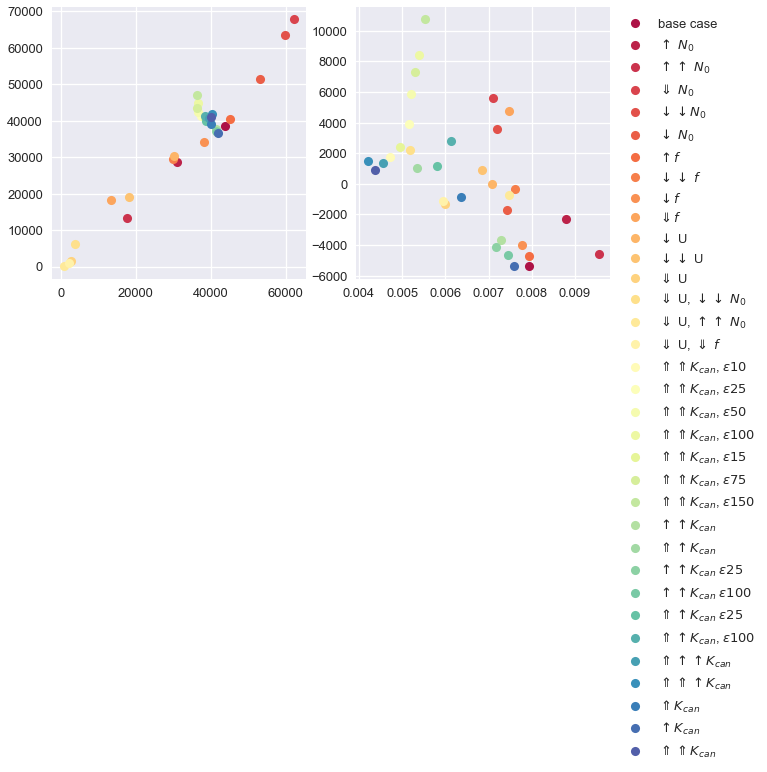

In [18]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.set_palette('Spectral',len(records_epsilon))

slope = 3.80
param = 0.97
intercept = -0.016

slope2 = 9.36
param2 = 1.06
intercept2 = -0.050

a = 20
b = 1

for rec in records_epsilon:
    
    rec.Neff = 0.3*rec.Nab_h+0.6*rec.Nbe_h
    
    nu = (rec.epsilon/(rec.kv/rec.N)) 
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u_mod,rec.f,W))/Ro(rec.u_mod,rec.f,L))**(1/2)))
    HA2013=((slope*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param*Se)**3))+intercept)
    RA2018=((slope2*(F(Ro(rec.u_mod,rec.f,W))**(3/2))*(Ro(rec.u_mod,rec.f,L)**(1/2))*((1-param2*Se)**3))+intercept2)
    
    rec.HA2013 = HA2013*(rec.u_mod*W*Dh(rec.f,L,rec.N))
    rec.RA2018 = RA2018*(rec.u_mod*W*Dh(rec.f,L,rec.Neff))

    ax[0].plot(rec.HA2013,rec.Phi,'o', label=rec.label2)
    ax[1].plot(rec.Neff,rec.Phi-rec.HA2013,'o', label=rec.label2)
#ax[0].plot(np.linspace(25000,45000,50),np.linspace(25000,45000,50),'-',color='0.5')
#ax[1].plot(np.linspace(25000,45000,50),np.linspace(25000,45000,50),'-',color='0.5')

ax[1].legend(bbox_to_anchor=(1,1))